# Extraction de features - Quartiers new yorkais
___

In [770]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Calque d'image pour les régions

In [773]:
from PIL import Image

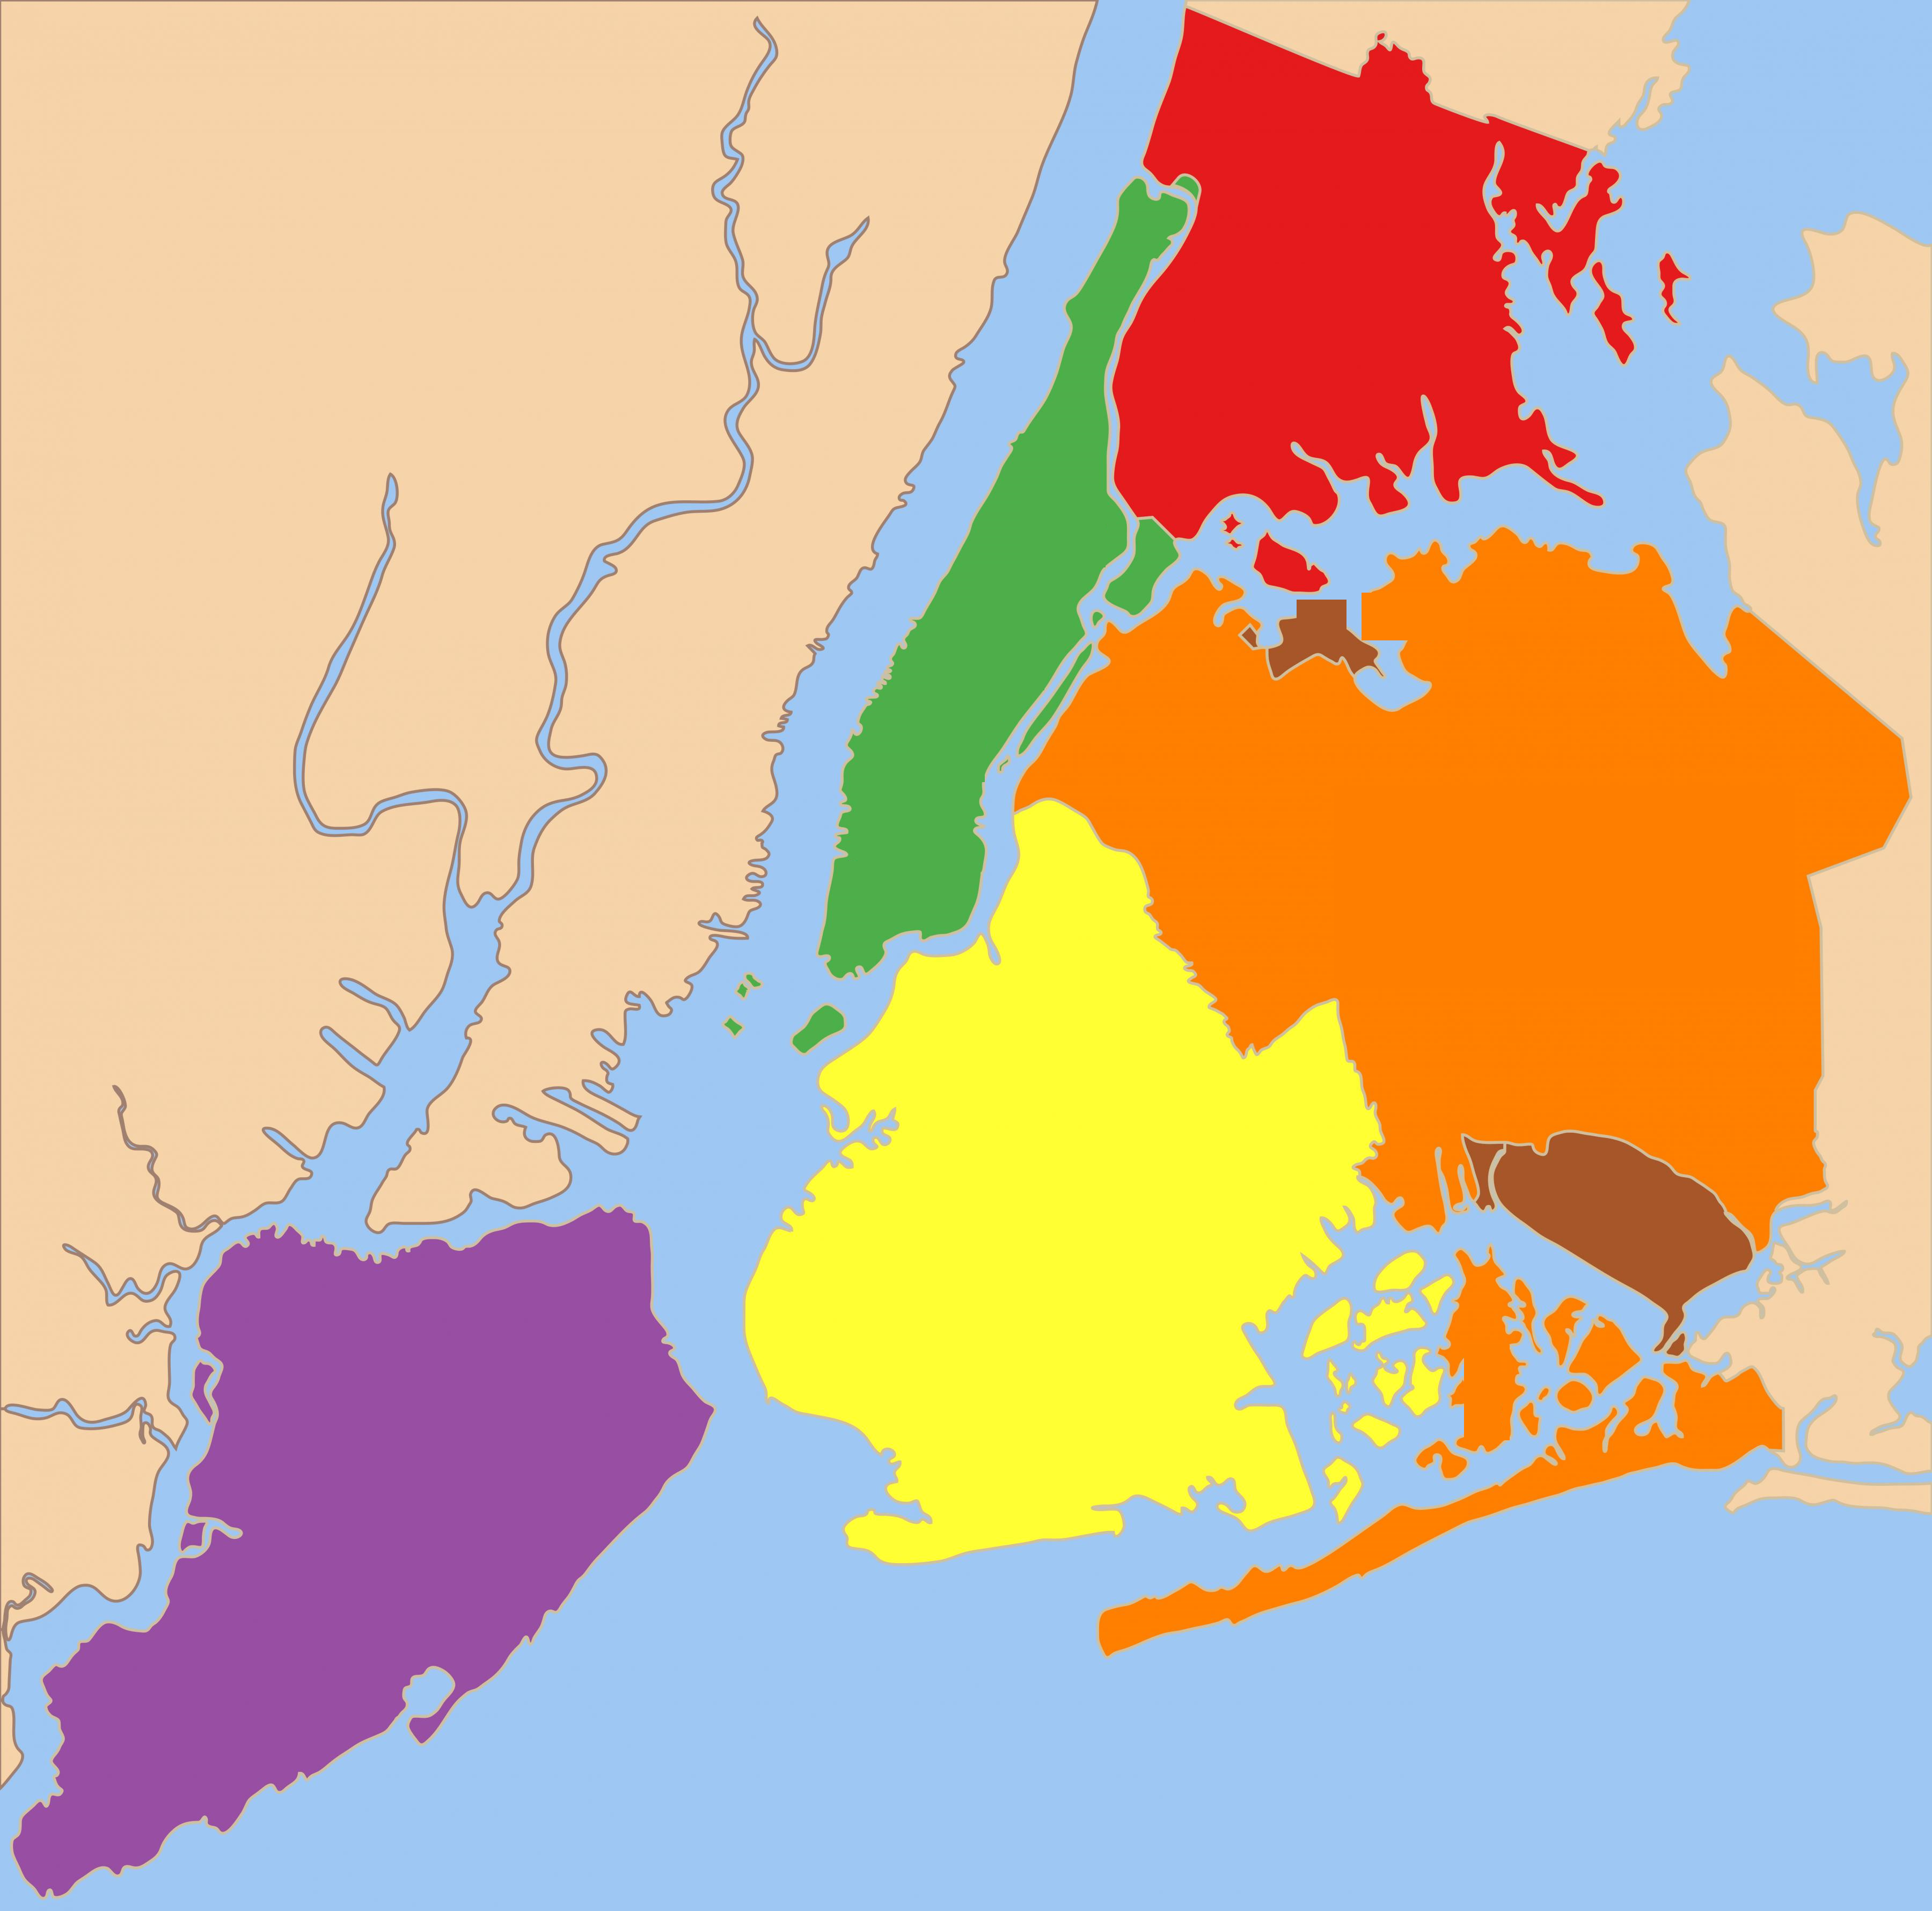

In [775]:
img = Image.open('data/nycmap.png').convert('RGB')
img

### Chargement des données longitude/latitude

In [778]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')

lon = np.array(list(train['PU_location_lon']) + list(test['PU_location_lon']) + list(train['DO_location_lon']) + list(test['DO_location_lon']))
lat = -np.array(list(train['PU_location_lat']) + list(test['PU_location_lat']) + list(train['DO_location_lat']) + list(test['DO_location_lat']))

### Superposition des données sur le calque

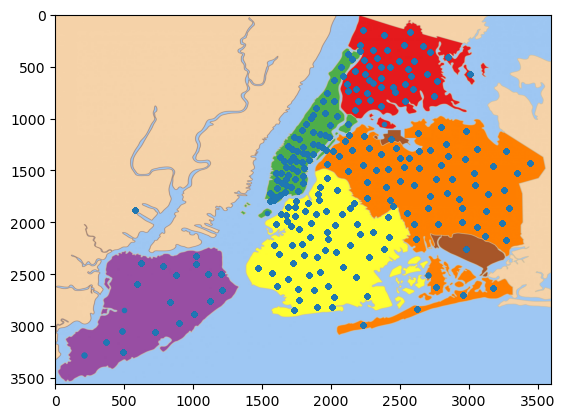

In [780]:
# callibrage des données sur le calque
x_translation = 1850
y_translation = 1370
scale_x = 6200
scale_y = 8350

xx = (lon - np.mean(lon))*scale_x + x_translation
yy = (lat - np.mean(lat))*scale_y + y_translation

plt.scatter(xx, yy, marker='.')
plt.imshow(img, aspect='auto')

### KMeans Clustering sur les couleurs

On veut identifier 7 classes correspondant aux 6 quartiers en couleurs (rouge, vert, orange, jaune, marron, violet) + une classe supplémentaire qui sera neutre (beige). Comme les couleurs des pixels peuvent être légèrement bruités, on récupère les couleurs aux coordonnées concernées et on classe les points :

In [815]:
xxi = xx.astype(int)
yyi = yy.astype(int)

In [817]:
npimg = np.array(img)
w, h = img.size
colors = np.array([npimg[yyi[i], xxi[i]] for i in range(len(xxi))])

In [818]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 7)
kmeans.fit(colors)

KMeans(n_clusters=7)

In [832]:
from matplotlib.colors import ListedColormap

cluster_colors = kmeans.cluster_centers_.astype(int)

color_map = ListedColormap(['green', 'brown', 'gold', 'orange', 'gray', 'magenta', 'purple'])

In [835]:
groups = kmeans.predict(colors)

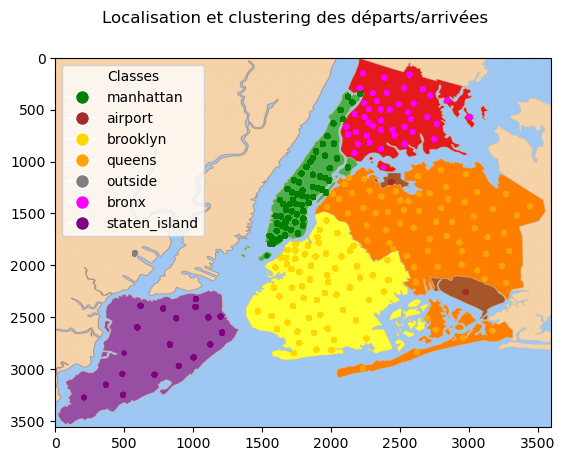

In [840]:
quarters = {
    0: 'manhattan',
    1: 'airport',
    2: 'brooklyn',
    3: 'queens',
    4: 'outside',
    5: 'bronx',
    6: 'staten_island'
}

plt.scatter(xxi, yyi, marker='.', c=groups, cmap=color_map)
plt.suptitle("Localisation et clustering des départs/arrivées")
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), markersize=10) for i in range(7)]
plt.legend(handles, quarters.values(), title="Classes")
plt.imshow(img, aspect='auto')
plt.savefig('fig/location.png')

### Affectation des quartiers et enregistrement des données

In [761]:
quarters = {
    0: 'manhattan',
    1: 'queens',
    2: 'airport',
    3: 'brooklyn',
    4: 'bronx',
    5: 'outside',
    6: 'staten_island'
}

t1 = len(train['PU_location_lon'])
t2 = len(test['PU_location_lon'])
t3 = len(train['PU_location_lon'])

train['PU_location'] = [quarters[i] for i in groups[0:t1]]
test['PU_location'] = [quarters[i] for i in groups[t1:t1+t2]]
train['DO_location'] = [quarters[i] for i in groups[t1+t2:t1+t2+t3]]
test['DO_location'] = [quarters[i] for i in groups[t1+t2+t3:]]

In [767]:
test

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
row_ID                                                                          
0               2  2024-01-24 08:02:47   2024-01-24 08:04:45              1.0   
1               2  2024-01-26 14:34:58   2024-01-26 14:42:51              1.0   
2               2  2024-01-24 15:47:27   2024-01-24 15:51:48              2.0   
3               2  2024-01-04 14:40:17   2024-01-04 14:44:21              1.0   
4               2  2024-01-16 05:54:03   2024-01-16 05:55:59              1.0   
...           ...                  ...                   ...              ...   
2627158         2  2024-01-09 14:22:25   2024-01-09 14:46:56              1.0   
2627159         2  2024-01-02 19:23:16   2024-01-02 19:39:51              1.0   
2627160         1  2024-01-28 12:29:13   2024-01-28 12:34:42              1.0   
2627161         2  2024-01-19 23:31:48   2024-01-19 23:40:43              2.0   
2627162         1  2024-01-17 11:29:07   2024-01-17 11:54:43              1.0   

         trip_distance  RatecodeID store_and_fwd_flag  payment_type  \
row_ID                                                                
0                 0.36         1.0                  N             1   
1                 1.78         1.0                  N             1   
2                 0.43         1.0                  N             2   
3                 0.61         1.0                  N             1   
4                 0.71         1.0                  N             2   
...                ...         ...                ...           ...   
2627158           4.33         1.0                  N             2   
2627159           1.70         1.0                  N             1   
2627160           0.80         1.0                  N             1   
2627161           2.20         1.0                  N             1   
2627162           1.60         1.0                  N             1   

         fare_amount  extra  ...  tolls_amount  improvement_surcharge  \
row_ID                       ...                                        
0                4.4    0.0  ...           0.0                    1.0   
1               10.7    0.0  ...           0.0                    1.0   
2                5.8    0.0  ...           0.0                    1.0   
3                5.8    0.0  ...           0.0                    1.0   
4                5.1    1.0  ...           0.0                    1.0   
...              ...    ...  ...           ...                    ...   
2627158         24.0    0.0  ...           0.0                    1.0   
2627159         14.9    2.5  ...           0.0                    1.0   
2627160          7.2    2.5  ...           0.0                    1.0   
2627161         12.1    1.0  ...           0.0                    1.0   
2627162         21.2    2.5  ...           0.0                    1.0   

         congestion_surcharge  Airport_fee  PU_location_lat  PU_location_lon  \
row_ID                                                                         
0                         2.5          0.0        40.740439       -73.976495   
1                         2.5          0.0        40.791705       -73.973049   
2                         0.0          0.0        40.791705       -73.973049   
3                         2.5          0.0        40.783961       -73.978632   
4                         2.5          0.0        40.748427       -73.999918   
...                       ...          ...              ...              ...   
2627158                   0.0          0.0        40.646985       -73.786530   
2627159                   2.5          0.0        40.759818       -73.984197   
2627160                   2.5          0.0        40.759818       -73.984197   
2627161                   2.5          0.0        40.736824       -73.984052   
2627162                   2.5          0.0        40.742279       -73.996971   

         DO_location_lat  DO_location_lo

In [765]:
train.to_parquet('data/train2.parquet', index=False)
test.to_parquet('data/test2.parquet', index=False)